In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from water_pollution.data.preproc import *
from water_pollution.data import stations
from water_pollution.data import weather

from water_pollution.data import visu

In [26]:
def plot_loss(history, title=None):
    fig = plt.figure(figsize=(20,7))
    
    # --- LOSS --- 
    ax = plt.gca()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylim((0,100))
    ax.legend(['Train', 'Test'], loc='best')
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

In [4]:
# Builds the small training df (from saone data between 2011-2021)
file_path = '../../raw_data/pc_saone_2011_2021/Analyses.CSV'
rawdf = get_rawdf_from_file(file_path)
da_df = build_saone_base_training_data(rawdf)

In [5]:
stationsdf = stations.get_saone_stations_df()
# stationsdf.sort_values('alt')

In [32]:
from tensorflow.keras import models, layers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
##### RESTART POINT
df = da_df.copy()

mean_nitrate = df.groupby('station_id',as_index=False).mean()[['station_id','nitrate']]
mean_nitrate.columns = ['station_id','mean_station']

df_with_mean = pd.merge(df,mean_nitrate,on='station_id',how='left')
df = df_with_mean

tempdf = weather.get_saone_weather_df(window_size=25,delta=5)
tempdf = tempdf[['date','temp','station_id']]

precdf = weather.get_saone_weather_df(window_size=35,delta=15)
precdf = precdf[['date','precipitation','station_id']]


df = pd.merge(df,tempdf,on=['date','station_id'],how='left')
df = df.dropna()
df = pd.merge(df,precdf,on=['date','station_id'],how='left')
df = df.dropna()

In [19]:
# TRAIN / TEST SPLIT

feature_cols = [
    'sin_doy',
    'cos_doy',
    'mean_station',
    #'precipitation',
    'temp',
    # 'source_dist',
    # 'year'
]

X = df[feature_cols]
y = df['nitrate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)#,random_state=1)

# PREPROCESSING

# Fit on X_train
scaler = StandardScaler()
scaler.fit(X_train)

# Transform all the X
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
def init_model(X):
    
    regl2 = regularizers.L2(0.001)
    
    model = models.Sequential()
    
    model.add( layers.Dense(30,activation='relu',input_dim=X.shape[1]) )
    #model.add( layers.Dropout(rate=0.2) )
    model.add( layers.Dense(30,activation='relu'))#,kernel_regularizer=regl2) )
    #model.add(layers.Dropout(rate=0.2))
    
    model.add( layers.Dense(20,activation='relu'))#,kernel_regularizer=regl2) )
    #model.add(layers.Dropout(rate=0.4))
    
    model.add(layers.Dense(1,activation='linear'))
    
    return model

model = init_model(X)
model.compile(loss='mse', optimizer='adam')

es = EarlyStopping(
	patience=100,
	monitor='val_loss',
	restore_best_weights=True
)

history = model.fit(
	X_train,y_train,
	epochs=2000,  # set it to a large value, early stoping will stop the fit
	batch_size=16, # good values : 16 or 32
	callbacks=[es],
	validation_data=(X_test, y_test),
	verbose=0
)

min(history.history['val_loss'])

6.377277851104736

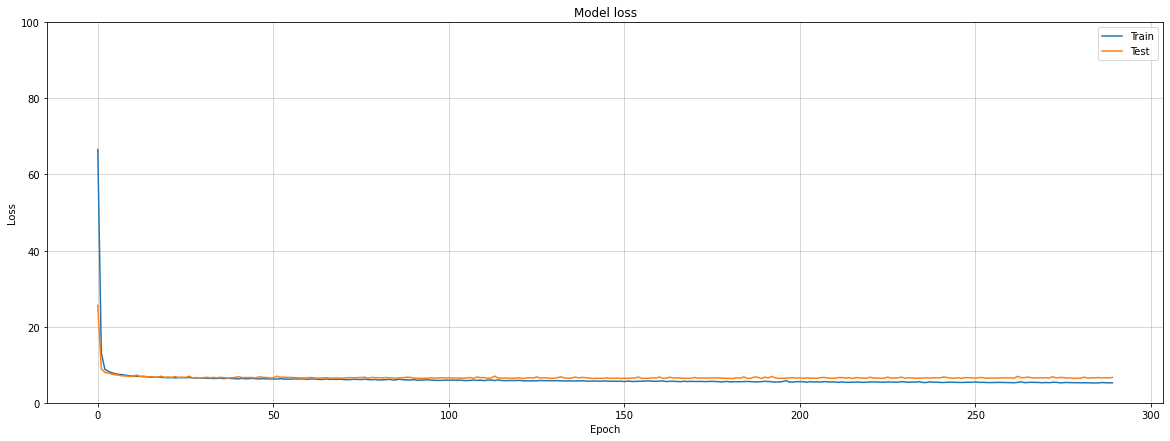

In [49]:
plot_loss(history)

6000990


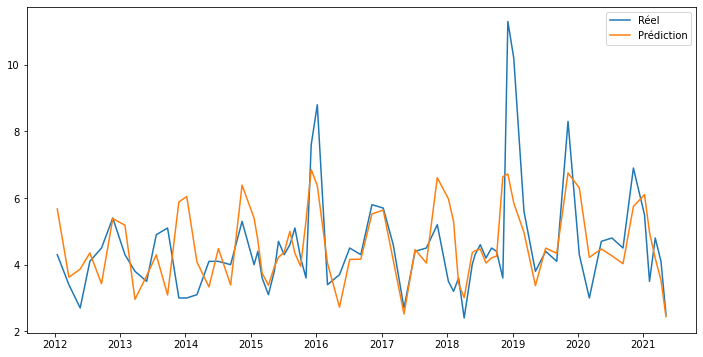

6000993


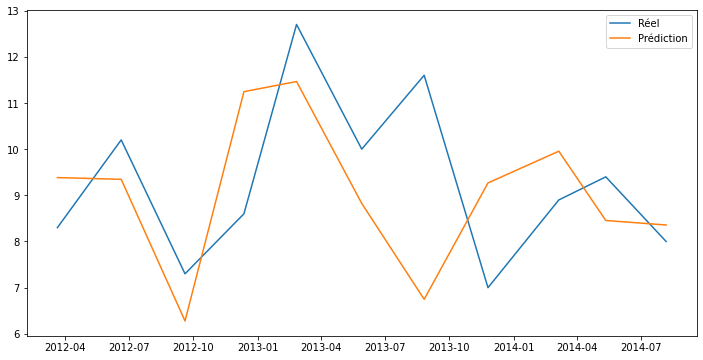

6000998


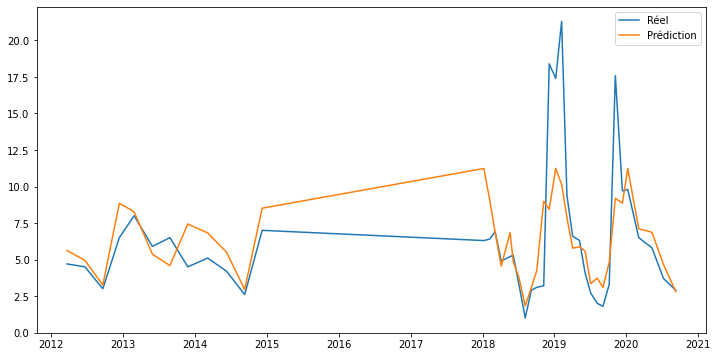

6001000


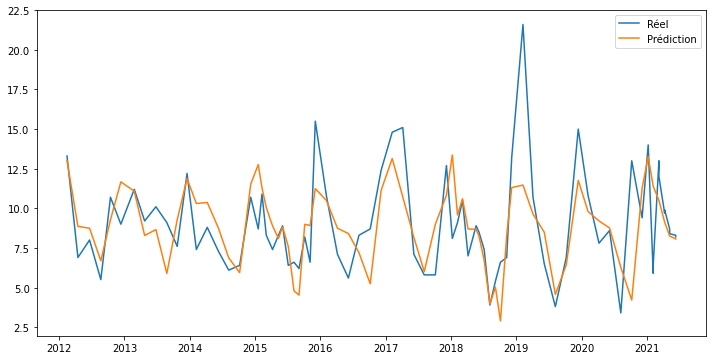

6002500


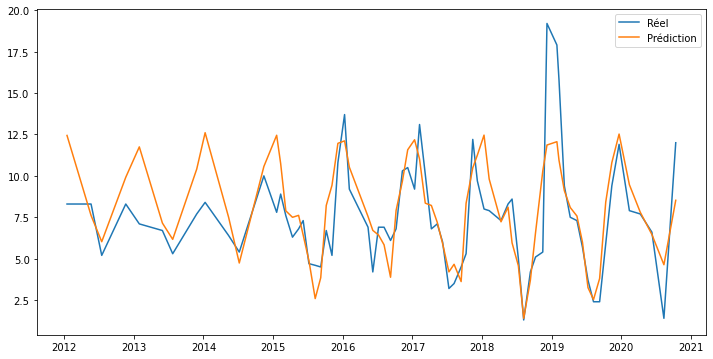

6003600


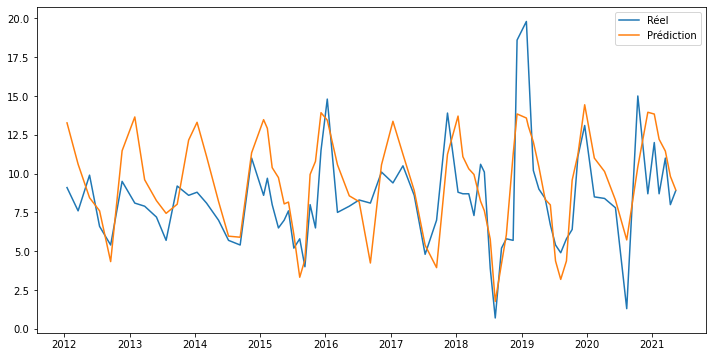

6005500


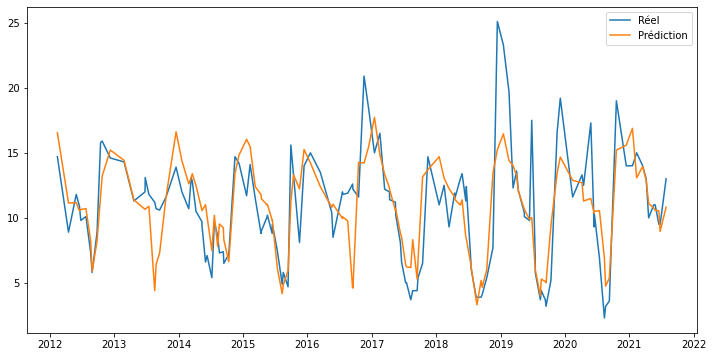

6011000


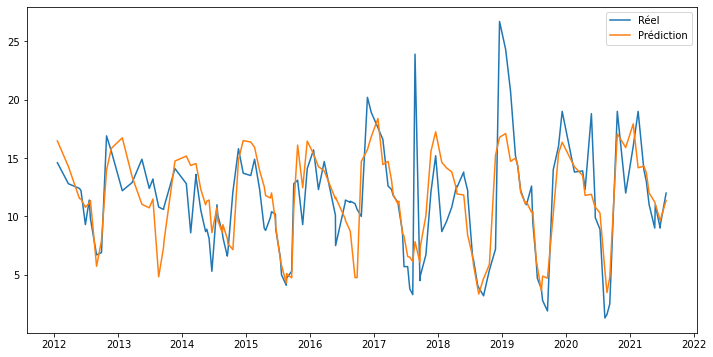

6017050


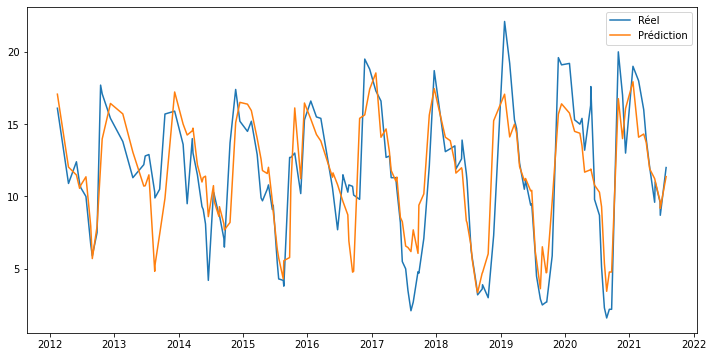

6017070


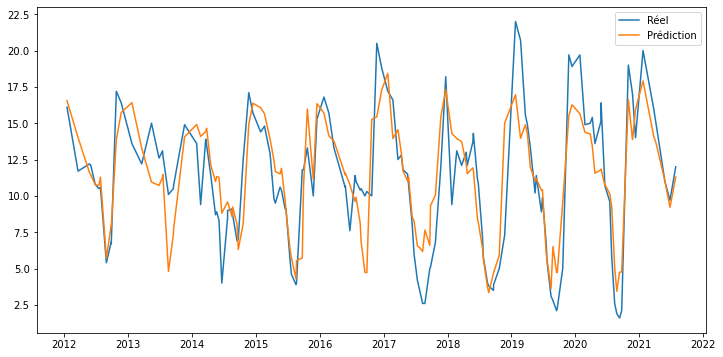

6037400


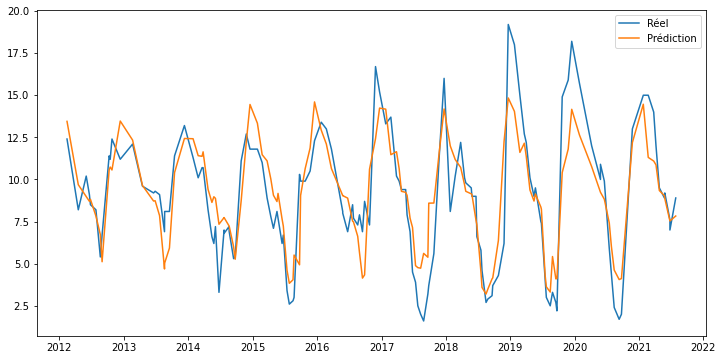

6039500


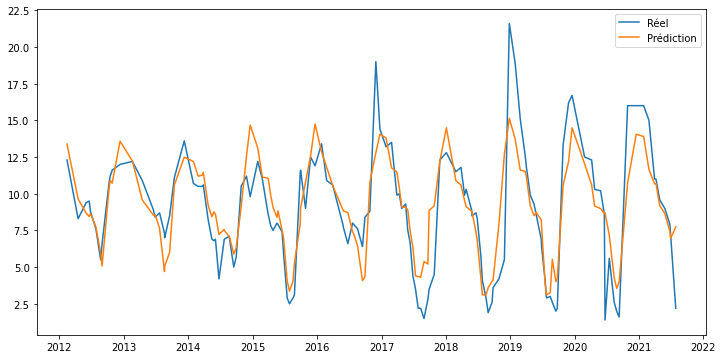

6045800


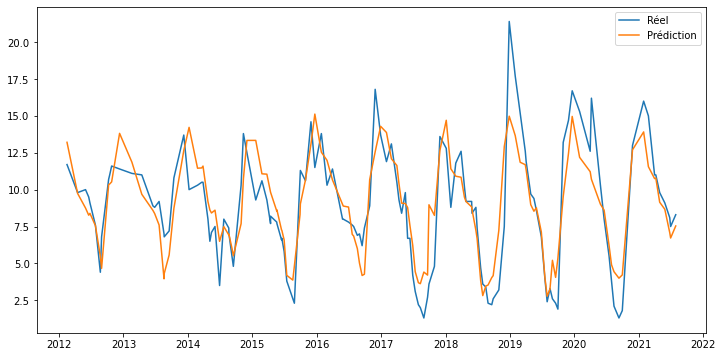

6053800


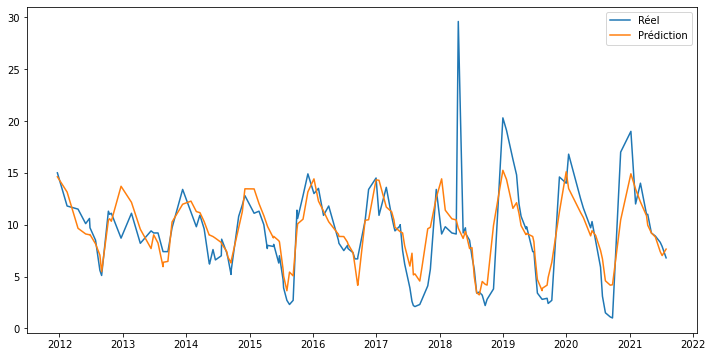

6059500


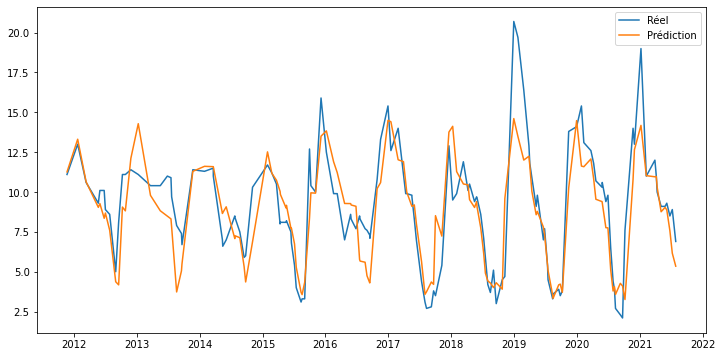

6810010


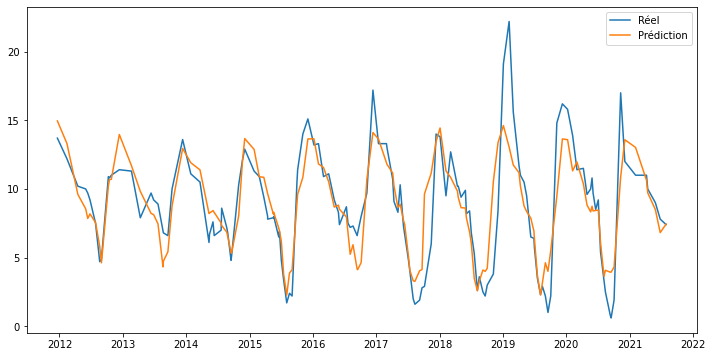

In [50]:
## PLOT STATI0NS PREDICTIONS

station_ids = list(df.station_id.unique())

for st_id in station_ids:
    
    print(st_id)

    # df of the station
    st_bool = df['station_id'] == st_id
    st_df = df[st_bool].sort_values('date') # copy sorted

    # X_station
    X_st = st_df[feature_cols]
    X_st = scaler.transform(X_st) # Scaling

    # y prediction
    y_st_pred = model.predict(X_st)
    st_df['nitrate_pred'] = y_st_pred

    plt.figure(figsize=(12,6))
    plt.plot(st_df['date'],st_df['nitrate'],label='Réel')
    plt.plot(st_df['date'],st_df['nitrate_pred'],label='Prédiction')
    plt.legend()
    plt.show()